# Analysis of adjancency matrices

In [6]:
import numpy as np
import json
import matplotlib.pyplot as plt
from skbio.stats.distance import mantel
from itertools import combinations

plt.style.use('dark_background')

KGTN_PATH = '/tf/KGTN2'

## Adjacency matrices as-is

In [39]:
distances_hierarchy = np.load(f'{KGTN_PATH}/KnowledgeGraphMatrix/HierarchyGraph.npy')
distances_glove = np.load(f'{KGTN_PATH}/KnowledgeGraphMatrix/SemanticGraph.npy')
distances_wikidata = np.load(f'{KGTN_PATH}/KnowledgeGraphMatrix/WikidataGraph.npy')

distances_dict = {
    'hierachy': distances_hierarchy,
    'glove': distances_glove,
    'wikidata': distances_wikidata,
}

Basic descriptive statistics

In [40]:
for k, v in distances_dict.items():
    print(f"{k:10} Min: {v.min():3.2f}   Avg: {v.mean():3.2f}   Max: {v.max():3.2f}   Std: {v.std():3.2f}")

hierachy   Min: 0.00   Avg: 9.76   Max: 10.00   Std: 1.20
glove      Min: 0.00   Avg: 8.52   Max: 14.31   Std: 1.29
wikidata   Min: 0.00   Avg: 5.82   Max: 12.73   Std: 1.32


Plots of lower triangles of distances matrices (excluding zeros) - in nominal and log scale.

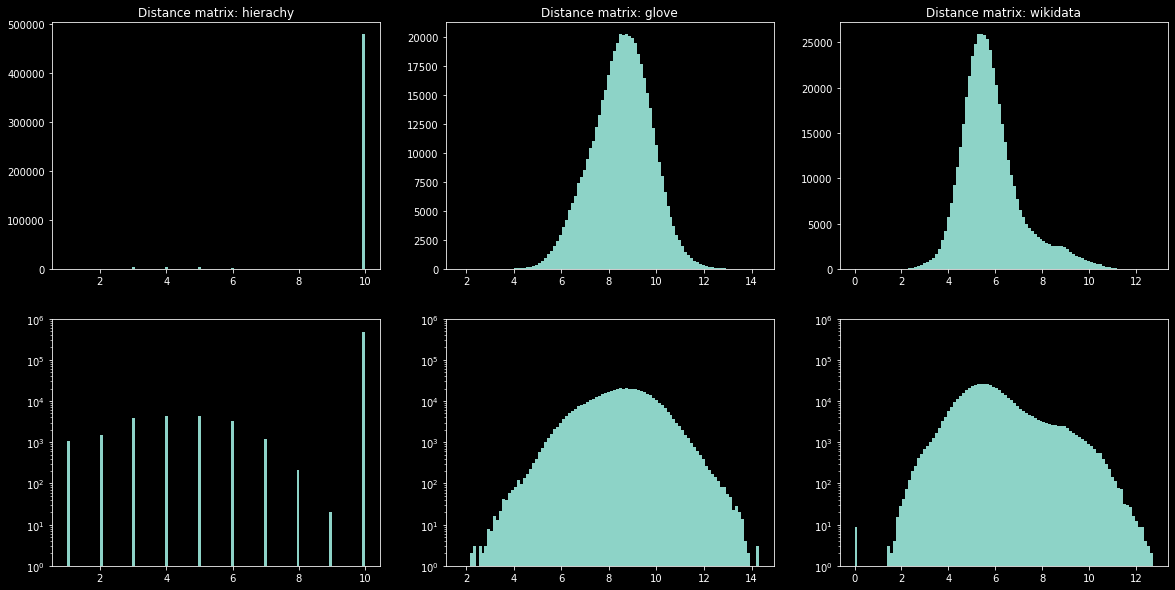

In [4]:
def plot_distinance_distribution(ax, k, v, log_scale=False):
    lower_triangle_flattened = np.tril(v).flatten()
    ax.hist(lower_triangle_flattened[lower_triangle_flattened.nonzero()[0]], bins=100)
    if log_scale:
        ax.set_yscale('log')
        ax.set_ylim(1, 1e6)
    else:
        ax.set_title(f"Distance matrix: {k}")
        # ax.set_ylim(0, 1e5)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, (k, v) in enumerate(distances_dict.items()):
    plot_distinance_distribution(axs[0, i], k, v, log_scale=False)
    plot_distinance_distribution(axs[1, i], k, v, log_scale=True)

fig.show()    

Mantel test for distance matrices correlations. Mantel test requires zeros on diagonal.

In [47]:
for k, v in distances_dict.items():
    print(f'Non-zero count in {k:8}: {np.count_nonzero(v)}, on diag: {np.count_nonzero(np.diagonal(v)):4}, total {v.size}')

Non-zero count in hierachy: 999000, on diag:    0, total 1000000
Non-zero count in glove   : 998996, on diag:    0, total 1000000
Non-zero count in wikidata: 999000, on diag:    0, total 1000000


In [5]:
for x, y in list(combinations(distances_dict.items(), 2)):
    corr, p, n = mantel(x[1], y[1])
    print(f"{x[0]:10} {y[0]:10}  corr: {corr:.2f}  p: {p}  n: {n}")

hierachy   glove       corr: 0.14  p: 0.001  n: 1000
hierachy   wikidata    corr: 0.13  p: 0.001  n: 1000
glove      wikidata    corr: 0.16  p: 0.001  n: 1000


## Transformations from `utils.py`

In [48]:
NUM_VALID=196+300+311
coefficient_glove = .4
coefficient_hierarchy = .5

kg_ratio = 100
use_all_base = True
label_idx_file = f"{KGTN_PATH}/DataSplit/KGTN/label_idx.json"
testsetup = 1

def get_ignore_ind(testsetup = 1, use_all_base = use_all_base, label_idx_file = label_idx_file):
    with open(label_idx_file, 'r') as f:
        lowshotmeta = json.load(f)
    novel_classes = lowshotmeta['novel_classes_1']
    novel2_classes = lowshotmeta['novel_classes_2']
    base_classes = lowshotmeta['base_classes_1']
    base2_classes = lowshotmeta['base_classes_2']
    if testsetup:
        if use_all_base:
            ignore_ind = novel_classes 
            valid_nodes = novel2_classes + base2_classes + base_classes
        else:
            ignore_ind = novel_classes + base_classes
            valid_nodes = novel2_classes + base2_classes
    else:
        if use_all_base:
            ignore_ind = novel2_classes
            valid_nodes = novel_classes + base2_classes + base_classes
        else:
            ignore_ind = novel2_classes + base2_classes
            valid_nodes = novel_classes + base_classes
    return ignore_ind, valid_nodes


def process_semantic(mat, coefficient, kg_ratio):
    ignore_ind, _ = get_ignore_ind()
    num_classes = mat.shape[0]
    mat[range(num_classes), range(num_classes)] = 999
    min_mat = np.min(mat, 1) 
    mat = mat - min_mat.reshape(-1, 1) + 1

    in_matrix = coefficient ** (mat - 1)
    in_matrix[:, ignore_ind] = 0
    in_matrix[ignore_ind, :] = 0
    in_matrix[range(num_classes), range(num_classes)] = 2
        
    # in the ascent order
    topk = int(NUM_VALID * kg_ratio / 100)
    max_ = -np.sort(-in_matrix, 1)
    edge = max_[:, topk].reshape(-1, 1)
    in_matrix[in_matrix < edge] = 0

    return in_matrix


def process_wordnet(mat, coefficient, kg_ratio):
    ignore_ind, _ = get_ignore_ind()
    num_classes = mat.shape[0]
    in_matrix = coefficient ** (mat - 1)
    in_matrix[range(num_classes), range(num_classes)] = 2
    in_matrix[ignore_ind, :] = 0
    in_matrix[:, ignore_ind] = 0
    # in the ascent order
    topk = int(NUM_VALID * kg_ratio / 100)
    max_ = -np.sort(-in_matrix, 1)
    edge = max_[:, topk].reshape(-1, 1)
    in_matrix[in_matrix < edge] = 0
    return in_matrix

distances_dict_processed = {
    'hierachy': process_wordnet(np.copy(distances_hierarchy), coefficient=coefficient_hierarchy, kg_ratio=kg_ratio),
    'glove': process_semantic(np.copy(distances_glove), coefficient=coefficient_glove, kg_ratio=kg_ratio),
    'wikidata': process_semantic(np.copy(distances_wikidata), coefficient=.25, kg_ratio=kg_ratio),
}


In [49]:
for k, v in distances_dict_processed.items():
    print(f"{k:10} Min: {v.min():3.2f}   Avg: {v.mean():3.2f}   Max: {v.max():3.2f}   Std: {v.std():3.2f}")

hierachy   Min: 0.00   Avg: 0.01   Max: 2.00   Std: 0.07
glove      Min: 0.00   Avg: 0.05   Max: 2.00   Std: 0.11
wikidata   Min: 0.00   Avg: 0.06   Max: 2.00   Std: 0.12


With coefficient $=25$, glove and wikidata distributions resemble themselves

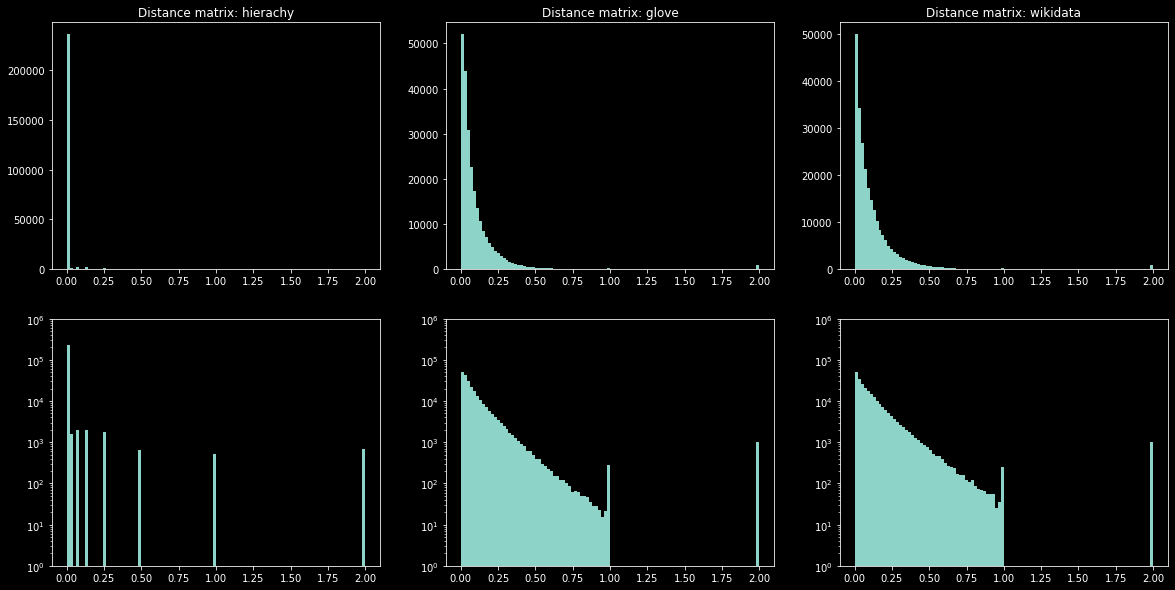

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, (k, v) in enumerate(distances_dict_processed.items()):
    plot_distinance_distribution(axs[0, i], k, v, log_scale=False)
    plot_distinance_distribution(axs[1, i], k, v, log_scale=True)

There are non-zeros on diagonal, which won't go with Mantel test

In [46]:
for k, v in distances_dict_processed.items():
    print(f'Non-zero count in {k:8}: {np.count_nonzero(v)}, on diag: {np.count_nonzero(np.diagonal(v)):4}, total {v.size}')

Non-zero count in hierachy: 490000, on diag:  700, total 1000000
Non-zero count in glove   : 490300, on diag: 1000, total 1000000
Non-zero count in wikidata: 490300, on diag: 1000, total 1000000


Let's fill diagonal with zeros (is it allowed...?)

In [ ]:
for x, y in list(combinations(distances_dict_processed.items(), 2)):
    corr, p, n = mantel(x[1], y[1])
    print(f"{x[0]:10} {y[0]:10}  corr: {corr:.2f}  p: {p}  n: {n}")